In [151]:
import csv
import math
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torchsummary
import matplotlib.pyplot as plt
from src.plot_utils import draw_pitch
from torchsummary import summary
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

#### Checking torch environment 

In [152]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

In [153]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS device is built: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS device is available: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.0.1
MPS device is built: True
MPS device is available: True
macOS-13.4-arm64-arm-64bit


#### Build custom dataset

In [154]:
class custom_dataset(Dataset):
    def __init__(self, file_path):
        data = pd.read_csv(file_path)
        data['Ball_x'] = data['Ball_x']/104
        data['loc_x'] = data['loc_x']/104
        data['Ball_y'] = data['Ball_y']/68
        data['loc_y'] = data['loc_y']/68
        self.columns = data.columns.to_list()
        self.y = data['v_kl'].values.reshape(-1, 1)
        self.x = data[['Ball_x', 'Ball_y', 'loc_x', 'loc_y']].values
        self.length = len(data)
    
    def __getitem__(self, index):
        x = torch.FloatTensor(self.x[index])
        y = torch.FloatTensor(self.y[index])
        return x, y
    
    def __len__(self):
        return self.length
    
    def column(self):
        return self.column

In [155]:
dataset = custom_dataset('./Data/dataset.csv')

#### Checking Datatsize

In [156]:
dataset_size = len(dataset)
print(dataset_size)

426006


In [157]:
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

#### Train-Test split

In [158]:
generator1 = torch.Generator().manual_seed(1)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [159]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024)

#### Simple Multi-layer neural network model

In [160]:
class nnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 24, bias=True)
        self.hidden2 = nn.Linear(24, 16, bias= True)
        self.hidden3 = nn.Linear(16, 8, bias= True)
        self.output = nn.Linear(8, 1, bias=True)
        #self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.output(x))

        return x
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.hidden1.weight)
        self.hidden1.bias.data.fill_(0.01)
        nn.init.kaiming_normal_(self.hidden2.weight)
        self.hidden2.bias.data.fill_(0.01)
        nn.init.kaiming_normal_(self.hidden3.weight)
        self.hidden3.bias.data.fill_(0.01)
        nn.init.kaiming_normal_(self.output.weight)
        self.output.bias.data.fill_(0.01)

In [161]:
model = nnModel()
model.reset_parameters()

In [162]:
summary(model, (128, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 128, 24]             120
            Linear-2              [-1, 128, 16]             400
            Linear-3               [-1, 128, 8]             136
            Linear-4               [-1, 128, 1]               9
Total params: 665
Trainable params: 665
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [163]:
model.to(device=device)

nnModel(
  (hidden1): Linear(in_features=4, out_features=24, bias=True)
  (hidden2): Linear(in_features=24, out_features=16, bias=True)
  (hidden3): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

#### Training

In [164]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# loss function
loss_fn = nn.MSELoss()

# training
train_loss_list=[]
test_loss_list=[]

n = len(train_dataloader)

epoch = 50
for i in range(epoch):
    model.train()
    train_loss = 0

    #load data
    for idx, data in enumerate(train_dataloader):
        x, y = data
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        #forward propagation
        y_pred = model(x)
        loss = loss_fn(y_pred,y)
        
        #backpropagation
        loss.backward()
        optimizer.step()

        train_loss += loss.mean()
        print('\r' + ''*100, end="")
        print('\r {}/{} batch_loss : {:.5f},  epochs: {}'.format(idx, n, loss.mean(), (i+1)), end="  ")
    
    train_loss /= n
    train_loss_list.append(train_loss.item())

    if (i+1)%10 == 1:
        print('\r' + ''*100, end="")
        print('\n epoch {}/{} train_loss : {:.5f}'.format(i+1, epoch, train_loss))

    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            
            y_pred = model(x)
            loss = loss_fn(y_pred,y)
            
            test_loss += loss.mean()

        test_loss /= len(test_dataloader)
        test_loss_list.append(test_loss.item())

        if (i+1)%10 == 1:
            print('\r' + ''*100, end="")
            print('epoch {}/{} test_loss : {:.5f} \n'.format(i+1, epoch, test_loss))

        if min(test_loss_list) >= test_loss.item():
            torch.save(model.state_dict(), './SpaceValueModel/best_svmodel_sdict.pt')

 332/333 batch_loss : 0.04103,  epochs: 1  
 epoch 1/50 train_loss : 0.06376
epoch 1/50 test_loss : 0.04248 

 332/333 batch_loss : 0.03828,  epochs: 11  
 epoch 11/50 train_loss : 0.03558
epoch 11/50 test_loss : 0.03506 

 332/333 batch_loss : 0.03160,  epochs: 21  
 epoch 21/50 train_loss : 0.03506
epoch 21/50 test_loss : 0.03499 

 332/333 batch_loss : 0.03218,  epochs: 31  
 epoch 31/50 train_loss : 0.03478
epoch 31/50 test_loss : 0.03455 

 332/333 batch_loss : 0.03453,  epochs: 41  
 epoch 41/50 train_loss : 0.03467
epoch 41/50 test_loss : 0.03440 

 332/333 batch_loss : 0.03714,  epochs: 50  

#### Learning curve

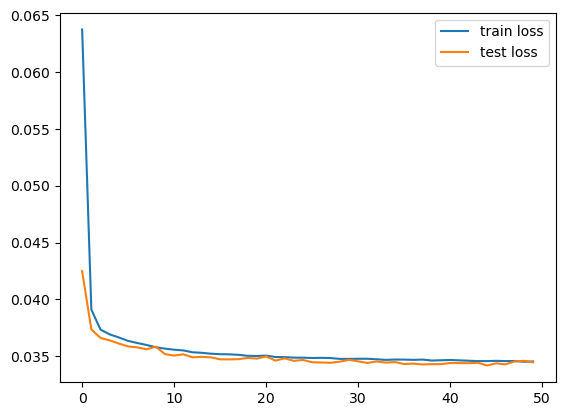

In [165]:
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend()

#### Loading best model

In [166]:
model.to('cpu')

nnModel(
  (hidden1): Linear(in_features=4, out_features=24, bias=True)
  (hidden2): Linear(in_features=24, out_features=16, bias=True)
  (hidden3): Linear(in_features=16, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [167]:
nn_model = nnModel()

In [168]:
nn_model.load_state_dict(torch.load('./SpaceValueModel/best_svmodel_sdict.pt'))

<All keys matched successfully>

#### Trained model evaluation

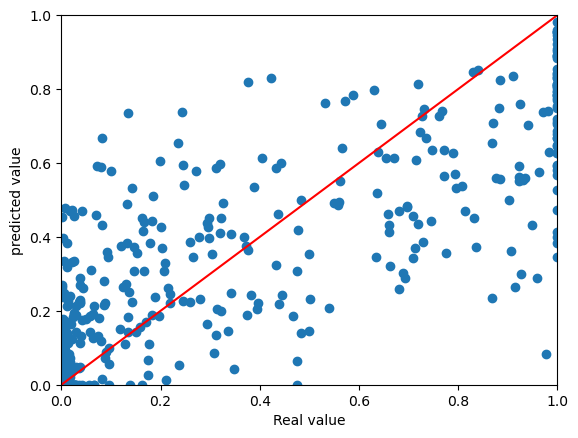

In [183]:
plt.scatter(test_dataset.dataset.y[:1000], nn_model(torch.Tensor(test_dataset.dataset.x[:1000])).detach().numpy())
plt.xlim((0, 1))
plt.xlabel('Real value')
plt.ylim((0, 1))
plt.ylabel('predicted value')
plt.plot(np.arange(0, 2, 0.1), np.arange(0, 2, 0.1), c='red')


### Space Value by ball's location

(52, 34)


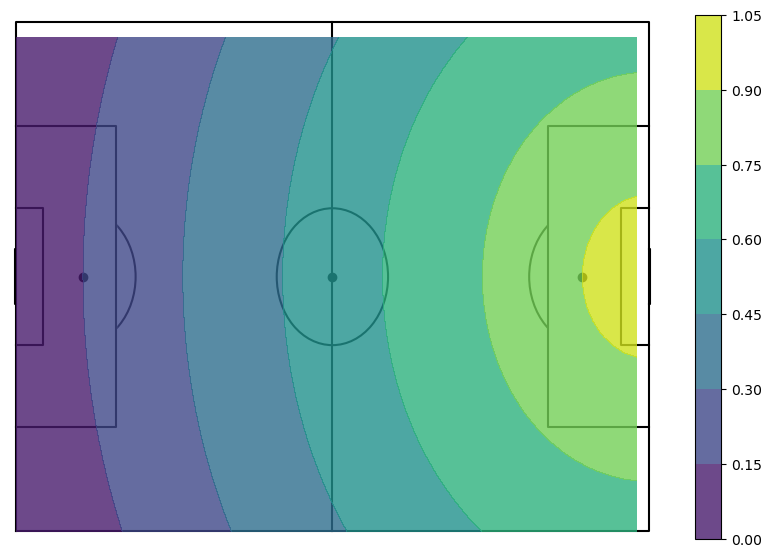

In [190]:
def distance_from_goal(x, y):
    dist = np.sqrt((104-x)**2 + (34-y)**2)
    max_v = np.max(dist)
    return (max_v - dist)/ (max_v)

x, y = np.mgrid[0:104:2, 0:68:2]
print(x.shape)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

z = distance_from_goal(x, y)
fig, ax = draw_pitch('white', 'black')


plt.contourf(x.reshape(52, 34), y.reshape(52, 34), z.reshape(52, 34), alpha=0.8)
plt.colorbar()

(0.0, 1.0)

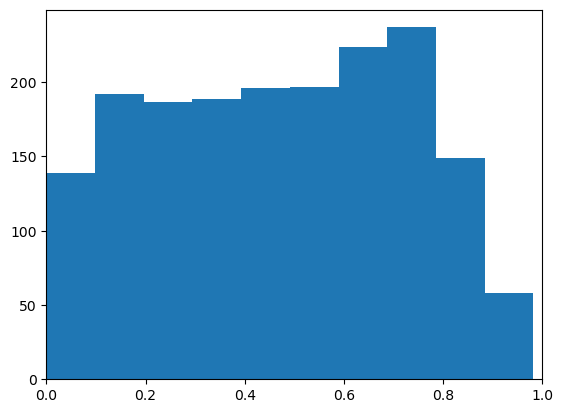

In [191]:
plt.hist(z)
plt.xlim((0, 1))

In [192]:
def plot_sv(ball, figx=None, normalize=False):
    x, y = np.mgrid[0:104:5, 0:68:5]
    x = x.reshape(-1, 1) /104
    y = y.reshape(-1, 1) /68
 
    ball_x = ball[0] * np.ones_like(x) / 104
    ball_y = ball[1] * np.ones_like(y) / 68

    input = torch.FloatTensor(np.concatenate([ball_x, ball_y, x, y], axis=1))
    output = model(input)
    output = output.detach().numpy()

    if normalize:
        z = distance_from_goal(x*104, y*68)
        output = output.reshape(-1) * z.reshape(-1) 
        
    if figx == None:
        fig, ax = draw_pitch('white', 'black')
        obj = ax.contourf(x.reshape(21, 14)*108, y.reshape(21, 14)*68, output.reshape(21, 14), alpha=0.8, vmin = 0, vmax = 1)
        ax.scatter(ball_x*104, ball_y*68, c='red')

    else:
        fig, ax = figx
        obj = ax.contourf(x.reshape(21, 14)*108, y.reshape(21, 14)*68, output.reshape(21, 14), alpha=0.8, vmin = 0, vmax = 1)
        ax.scatter(ball_x*104, ball_y*68, c='red')

    return fig, ax, obj

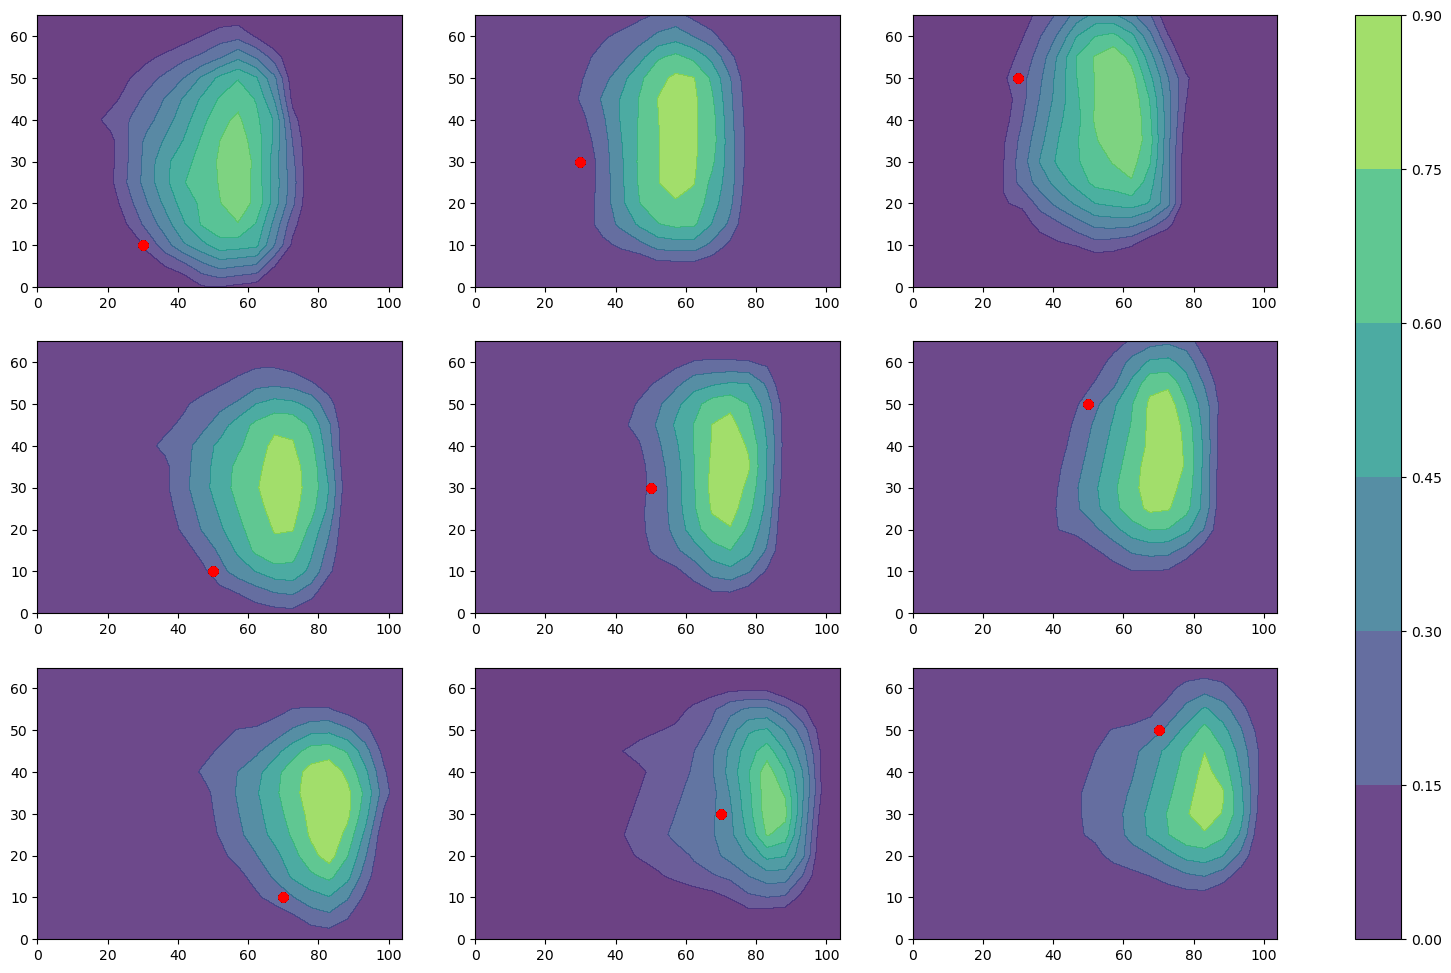

In [193]:
l_x, l_y = np.mgrid[30:80:20, 10:70:20]
ball_locations = np.concatenate([l_x.reshape(-1,1), l_y.reshape(-1,1)], axis=1)
fig, axs = plt.subplots(3, 3, figsize=(20, 12))
plt.set_cmap('viridis')
for i, ball in enumerate(ball_locations):
    x = i//3
    y = i%3
    fig, axs[x, y], obj = plot_sv(ball, figx=(fig, axs[x, y]))

plt.colorbar(obj, ax=axs)
plt.show()

In [194]:
ball_x = 40
ball_y = 40

#################################
x, y = np.mgrid[0:104:5, 0:68:5]
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
z = distance_from_goal(x, y)
x = x/104
y = y/68 
ball_x = ball_x * np.ones_like(x) / 104
ball_y = ball_y * np.ones_like(y) / 68

input = torch.FloatTensor(np.concatenate([ball_x, ball_y, x, y], axis=1))
output = model(input)
output = output.detach().numpy()

(0.0, 1.0)

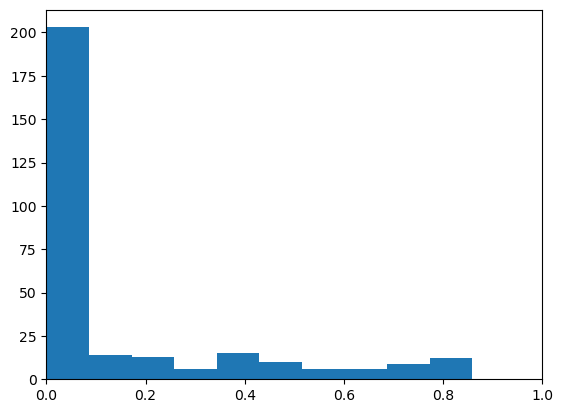

In [195]:
plt.hist(output)
plt.xlim((0, 1))

(0.0, 1.0)

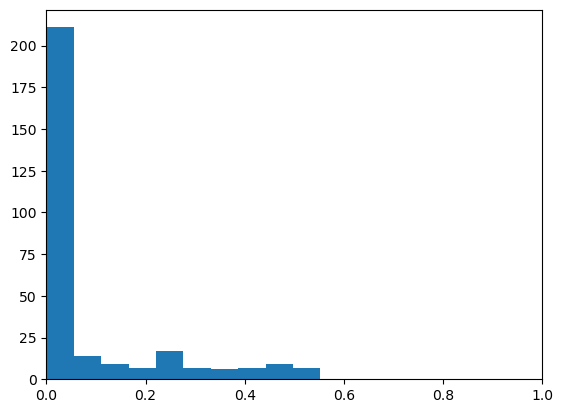

In [196]:
plt.hist(z.reshape(-1) * output.reshape(-1))
plt.xlim(0, 1)

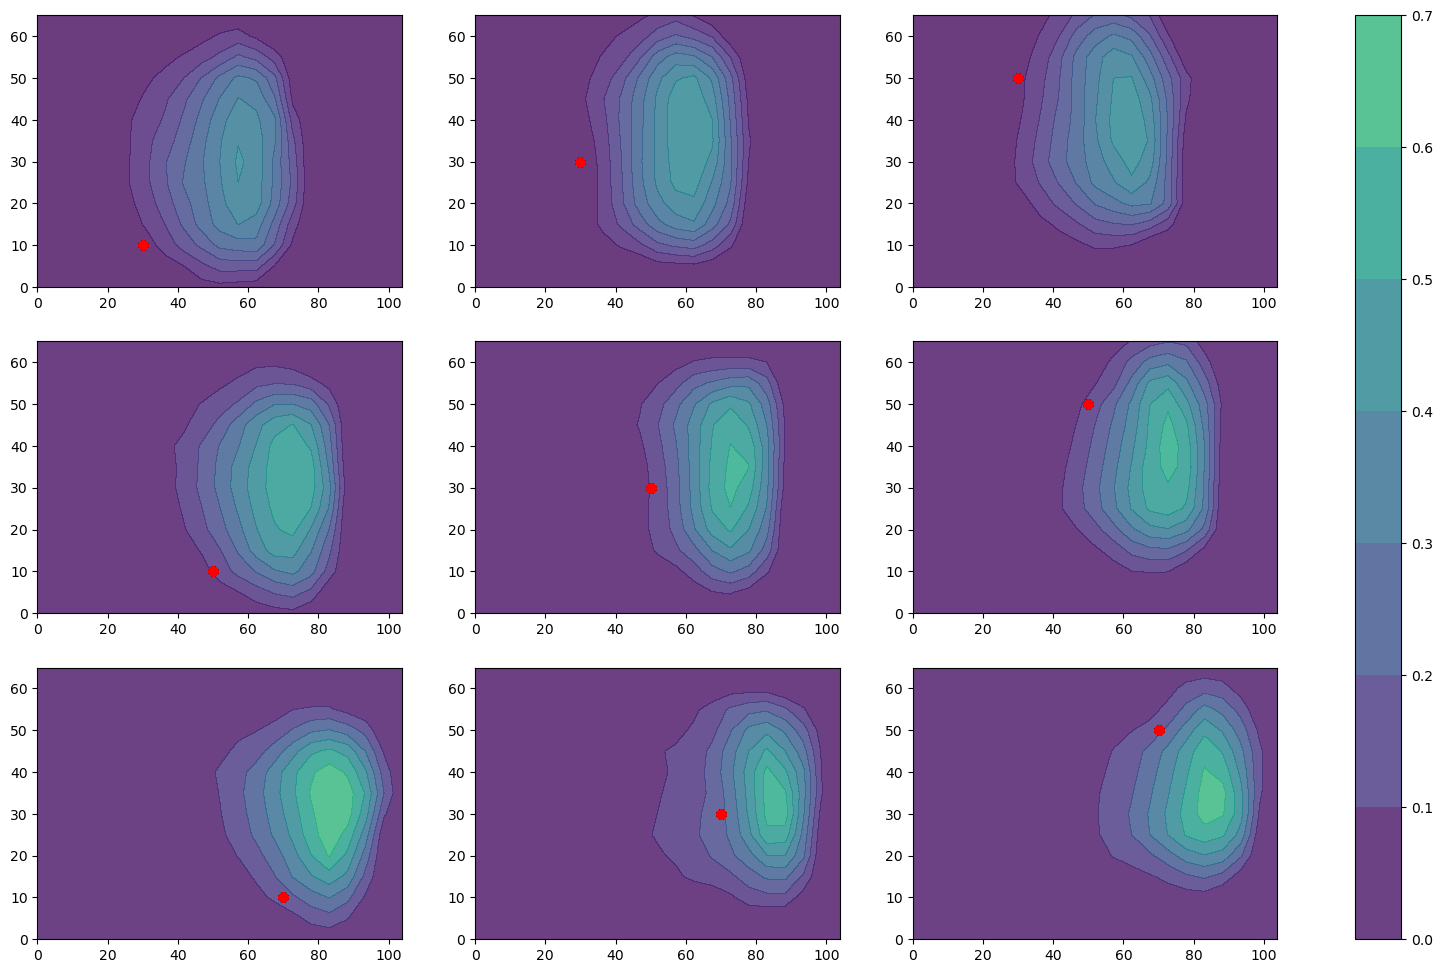

In [197]:
fig, axs = plt.subplots(3, 3, figsize=(20, 12))
plt.set_cmap('viridis')

for i, ball in enumerate(ball_locations):
    x = i//3
    y = i%3
    fig, axs[x, y], obj = plot_sv(ball, figx=(fig, axs[x, y]), normalize=True)

plt.colorbar(obj, ax=axs)